# Explo Schultz–Dayan–Montague (1997)
*(Temporal Difference, prédiction de récompense, “signal dopaminergique”)*


## 0) Recap

Le papier relie des observations neurophysiologiques à un modèle TD.

**Observation clé :**
- Avant apprentissage : réponse dopaminergique au **reward inattendu**.
- Après apprentissage : réponse au **stimulus prédictif (CS)**, et plus au reward attendu.
- Si reward omis : **dépression** au moment où le reward était attendu.

**Modèle TD minimal :**
- une valeur prédite $\hat V(t)$
- une erreur TD $\delta(t)$
- une mise à jour des poids en fonction de $x(t)\,\delta(t)$

Équations (telles qu’on les utilise ici) :
- Valeur : $\hat V(t) = \sum_i w_i x_i(t)$  
- Erreur TD : $\delta(t) = r(t) + \gamma \hat V(t+1) - \hat V(t)$  
- Mise à jour : $\Delta w_i = \alpha \, x_i(t)\,\delta(t)$


## 1) Représenter le temps : “serial compound”

Point important du papier : un seul poids par stimulus ne suffit pas pour apprendre le **timing**.
On utilise donc une représentation *dépliée dans le temps*.

Idée : si le cue (CS) arrive au temps $t_{CS}$, on crée des “traces” :
- $x_1(t)$ s’allume à $t_{CS}+1$
- $x_2(t)$ s’allume à $t_{CS}+2$
- ...
Chaque trace a son propre poids $w_i$.

Cela permet à un même CS de prédire un reward à des délais arbitraires (dans la limite des délais qu’on a définis).


## Limites du modèle TD utilisé

Ce modèle est volontairement simplifié :
- il suppose une représentation du temps déjà construite (serial compound),
- il utilise une fonction de valeur linéaire,
- il ne modélise pas explicitement la dopamine, seulement un signal d’erreur.

Le modèle n’explique donc pas *comment* le cerveau représente le temps, 
mais *comment* un signal d’erreur temporelle peut émerger **si** cette représentation existe.


➡️ Prédiction expérimentale

Si le signal dopaminergique correspond à l’erreur TD δ(t), alors :
- un reward inattendu doit produire une activation dopaminergique,
- après apprentissage, cette activation doit se déplacer vers le cue,
- l’omission du reward doit produire une dépression au temps attendu.

Ces prédictions correspondent précisément aux résultats observés chez le singe.


In [129]:
import numpy as np

class TDSerialCompound:
    """
    Modèle TD minimal inspiré du papier :
    - Représentation 'serial compound' du cue : x_i(t) (1 à un délai i après le cue)
    - Valeur linéaire : Vhat(t) = sum_i w_i x_i(t)
    - Erreur TD : delta(t) = r(t) + gamma * Vhat(t+1) - Vhat(t)
    - Apprentissage : w += alpha * x(t) * delta(t)

    - modèle minimal avec un seul cue et une seule récompense par trial
    """
    def __init__(self, T=80, cue_time=10, reward_time=60, n_delays=60, alpha=0.05, gamma=0.98):
        self.T = int(T)
        self.cue_time = int(cue_time)
        self.reward_time = int(reward_time)
        self.n_delays = int(n_delays)
        self.alpha = float(alpha)
        self.gamma = float(gamma)
        self.w = np.zeros(self.n_delays, dtype=float)

    def x(self, t: int) -> np.ndarray:
        """Vecteur one-hot indiquant le délai depuis le cue."""
        vec = np.zeros(self.n_delays, dtype=float)
        delay = t - self.cue_time - 1
        if 0 <= delay < self.n_delays:
            vec[delay] = 1.0
        return vec

    def Vhat(self, t: int) -> float:
        return float(np.dot(self.w, self.x(t)))

    def run_trial(self, reward_delivered=True, reward_value=1.0):
        """
        Fait un 'trial' et apprend en ligne.
        Renvoie : deltas, Vhats, rewards
        """
        r = np.zeros(self.T, dtype=float)
        if reward_delivered and 0 <= self.reward_time < self.T:
            r[self.reward_time] = float(reward_value)

        deltas = np.zeros(self.T, dtype=float)
        Vhats = np.zeros(self.T, dtype=float)

        for t in range(self.T):
            Vt = self.Vhat(t)
            Vnext = self.Vhat(t+1) if t+1 < self.T else 0.0
            delta = r[t] + self.gamma * Vnext - Vt
            self.w += self.alpha * self.x(t) * delta
            deltas[t] = delta
            Vhats[t] = Vt

        return deltas, Vhats, r


## 2) Entraîner sur une tâche “cue → reward”

Setup :
- cue à $t=10$
- reward à $t=60$
- on entraîne sur plusieurs trials identiques

Ce que je veux observer :
- au début : $\delta(t)$ gros au moment du reward
- à la fin : $\delta(t)$ se déplace vers le cue


In [130]:
import matplotlib.pyplot as plt

def entrainer_modele(alpha=0.05, gamma=0.98, reward_time=60, n_train=80, T=80, cue_time=10, n_delays=60):
    model = TDSerialCompound(T=T, cue_time=cue_time, reward_time=reward_time,
                             n_delays=n_delays, alpha=alpha, gamma=gamma)
    train_deltas = []
    train_V = []
    for _ in range(n_train):
        d, V, r = model.run_trial(reward_delivered=True, reward_value=1.0)
        train_deltas.append(d)
        train_V.append(V)
    return model, np.array(train_deltas), np.array(train_V)

model, train_deltas, train_V = entrainer_modele(alpha=0.05, gamma=0.98, reward_time=60, n_train=80)

t = np.arange(model.T)
cue_t = model.cue_time
rew_t = model.reward_time

# Trial d'omission (reward absent)
omit_delta, omit_V, omit_r = model.run_trial(reward_delivered=False, reward_value=1.0)

print("Paramètres:", {"alpha": model.alpha, "gamma": model.gamma, "cue_time": cue_t, "reward_time": rew_t, "n_delays": model.n_delays})


Paramètres: {'alpha': 0.05, 'gamma': 0.98, 'cue_time': 10, 'reward_time': 60, 'n_delays': 60}


## 3) Graphe principal : $\delta(t)$ “début vs fin”

Interprétation :
- $\delta(t)$ = “surprise” / erreur de prédiction
- au début : reward inattendu → grosse surprise positive au reward
- après apprentissage : le cue prédit le reward → surprise au cue, et ~0 au reward


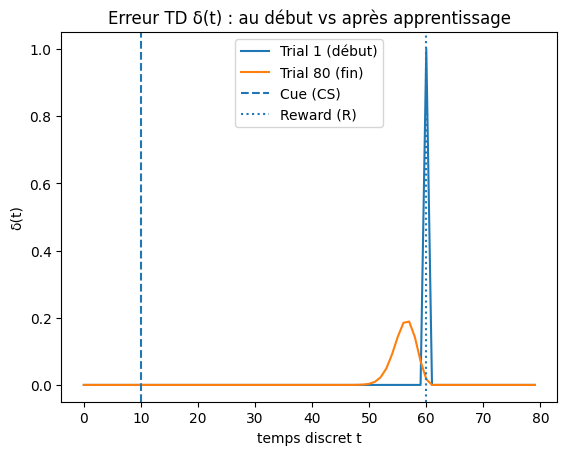

Pic δ(t) trial 1: 60 val= 1.0
Pic δ(t) trial fin: 57 val= 0.18864417991387517


In [131]:
plt.figure()
plt.plot(t, train_deltas[0], label="Trial 1 (début)")
plt.plot(t, train_deltas[-1], label=f"Trial {len(train_deltas)} (fin)")
plt.axvline(cue_t, linestyle="--", label="Cue (CS)")
plt.axvline(rew_t, linestyle=":", label="Reward (R)")
plt.title("Erreur TD δ(t) : au début vs après apprentissage")
plt.xlabel("temps discret t")
plt.ylabel("δ(t)")
plt.legend()
plt.show()

print("Pic δ(t) trial 1:", int(np.argmax(train_deltas[0])), "val=", float(np.max(train_deltas[0])))
print("Pic δ(t) trial fin:", int(np.argmax(train_deltas[-1])), "val=", float(np.max(train_deltas[-1])))


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Au début de l’apprentissage, on observe un pic marqué de l’erreur TD δ(t) exactement au moment de la délivrance de la récompense. Cela indique que la récompense est initialement totalement imprévisible pour le modèle. Après entraînement, ce pic disparaît au moment de la récompense et apparaît juste après le stimulus prédictif (cue). Cette évolution montre que le modèle a appris à prédire la récompense à partir du cue, et que l’erreur de prédiction se déplace du reward vers le signal prédictif.
</div>


## 4) Omission du reward : $\delta(t)$ devient négatif au temps attendu

Après apprentissage, le modèle “s’attend” au reward.  
Si le reward n’arrive pas, on doit voir une chute (dépression) au temps du reward attendu.


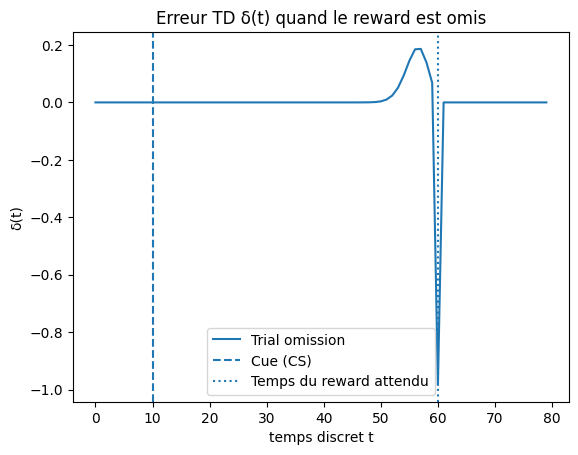

Minimum δ(t) omission: 60 val= -0.9834846256149865


In [132]:
plt.figure()
plt.plot(t, omit_delta, label="Trial omission")
plt.axvline(cue_t, linestyle="--", label="Cue (CS)")
plt.axvline(rew_t, linestyle=":", label="Temps du reward attendu")
plt.title("Erreur TD δ(t) quand le reward est omis")
plt.xlabel("temps discret t")
plt.ylabel("δ(t)")
plt.legend()
plt.show()

print("Minimum δ(t) omission:", int(np.argmin(omit_delta)), "val=", float(np.min(omit_delta)))


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Lorsque la récompense est omise après apprentissage, on observe une forte dépression négative de δ(t) précisément au moment où la récompense était attendue. Cela signifie que le modèle prédisait une récompense future qui n’a pas été délivrée. Ce comportement reproduit fidèlement la chute d’activité dopaminergique observée expérimentalement et montre que le système encode non seulement la prédiction du reward, mais aussi son timing.
</div>


## 5) Comment la valeur $\hat V(t)$ se construit

$\hat V(t)$ représente la somme (discountée) des rewards futurs attendus.  
On trace $\hat V(t)$ sur plusieurs trials pour voir l’apparition progressive d’une attente de reward.


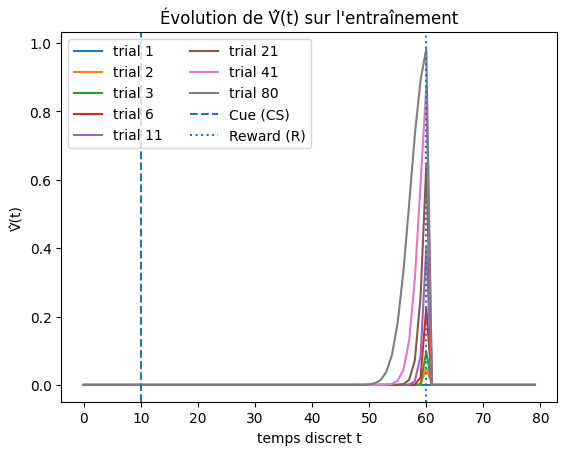

In [133]:
plt.figure()
for k in [0, 1, 2, 5, 10, 20, 40, 79]:
    plt.plot(t, train_V[k], label=f"trial {k+1}")
plt.axvline(cue_t, linestyle="--", label="Cue (CS)")
plt.axvline(rew_t, linestyle=":", label="Reward (R)")
plt.title("Évolution de V̂(t) sur l'entraînement")
plt.xlabel("temps discret t")
plt.ylabel("V̂(t)")
plt.legend(ncol=2)
plt.show()


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Ce graphe montre l’évolution de la valeur estimée V̂(t) au cours de l’entraînement pour différents trials. Au début (trial 1, 2, 3), V̂(t) est quasiment nulle à tous les instants, ce qui indique que le modèle n’a encore aucune anticipation de récompense. Au fil de l’apprentissage, V̂(t) commence à augmenter dans la fenêtre temporelle précédant la récompense, avec une croissance de plus en plus précoce et marquée. Après de nombreux trials (trial 80), la valeur V̂(t) devient élevée juste avant le temps de la récompense, ce qui signifie que le modèle a appris à prédire l’arrivée future du reward à partir du cue. Ce graphe illustre ainsi la construction progressive d’une anticipation temporelle de la récompense, cœur du mécanisme de prédiction décrit dans le papier.
</div>


## 6) heatmap de $\delta(t)$ sur les trials

Une heatmap (trial en ordonnée, temps en abscisse) donne une intuition très claire :
- au début, l’activité est concentrée au reward
- puis ça “remonte” vers le cue au fil des trials


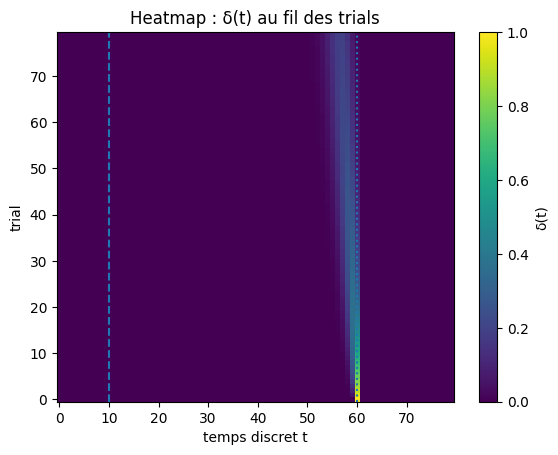

In [134]:
plt.figure()
plt.imshow(train_deltas, aspect="auto", origin="lower")
plt.colorbar(label="δ(t)")
plt.axvline(cue_t, linestyle="--")
plt.axvline(rew_t, linestyle=":")
plt.title("Heatmap : δ(t) au fil des trials")
plt.xlabel("temps discret t")
plt.ylabel("trial")
plt.show()


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
La heatmap permet de visualiser l’évolution de l’erreur TD sur tous les trials. On observe qu’au début de l’apprentissage, l’activité est concentrée au moment de la récompense. Progressivement, cette activité se déplace vers le cue, formant une bande diagonale caractéristique. Cette visualisation illustre clairement le mécanisme de propagation temporelle de l’erreur de prédiction décrit par l’apprentissage Temporal Difference.
</div>


## 7) Exploration 1 — Effet du taux d’apprentissage $\alpha$

Intuition :
- $\alpha$ petit → apprentissage lent (le transfert cue←reward prend plus de trials)
- $\alpha$ grand → apprentissage rapide mais peut être instable

On compare plusieurs valeurs de $\alpha$ et on regarde où se trouve $\delta(t)$ final.


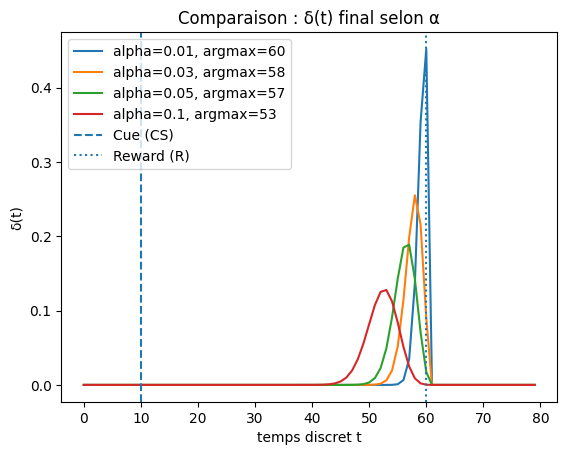

In [135]:
alphas = [0.01, 0.03, 0.05, 0.1]
plt.figure()
for a in alphas:
    m, d, V = entrainer_modele(alpha=a, gamma=0.98, reward_time=60, n_train=80)
    late = d[-1]
    plt.plot(np.arange(m.T), late, label=f"alpha={a}, argmax={int(np.argmax(late))}")
plt.axvline(10, linestyle="--", label="Cue (CS)")
plt.axvline(60, linestyle=":", label="Reward (R)")
plt.title("Comparaison : δ(t) final selon α")
plt.xlabel("temps discret t")
plt.ylabel("δ(t)")
plt.legend()
plt.show()


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Un α faible déplace lentement δ(t) du reward vers le cue; un α plus grand accélère ce transfert mais rend les pics plus abrupts. α règle donc la vitesse d’apprentissage, sans changer le pattern attendu.
</div>


## 8) Exploration 2 — Effet du facteur d’actualisation $\gamma$

Intuition :
- $\gamma$ proche de 1 → plus d'importance au futur → anticipation plus forte
- $\gamma$ plus petit → reward lointain “compte moins”

On compare plusieurs $\gamma$.


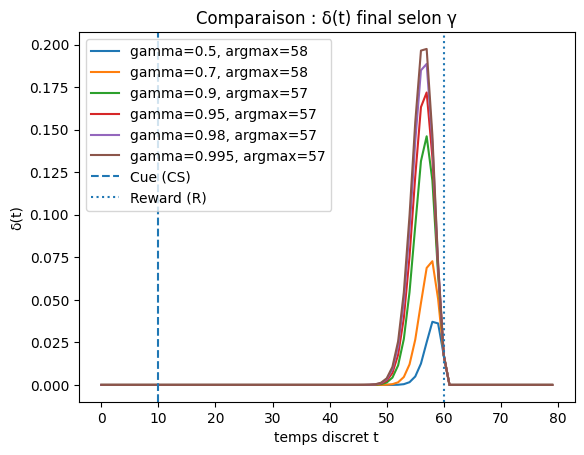

In [136]:
gammas = [0.5,0.7,0.9, 0.95, 0.98, 0.995]
plt.figure()
for g in gammas:
    m, d, V = entrainer_modele(alpha=0.05, gamma=g, reward_time=60, n_train=80)
    late = d[-1]
    plt.plot(np.arange(m.T), late, label=f"gamma={g}, argmax={int(np.argmax(late))}")
plt.axvline(10, linestyle="--", label="Cue (CS)")
plt.axvline(60, linestyle=":", label="Reward (R)")
plt.title("Comparaison : δ(t) final selon γ")
plt.xlabel("temps discret t")
plt.ylabel("δ(t)")
plt.legend()
plt.show()


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Un γ proche de 1 maintient la valeur du reward lointain et favorise une anticipation nette. Un γ plus petit amortit les récompenses éloignées, d’où un δ(t) moins concentré sur le timing exact.
</div>


## 9) Exploration 3 — Déplacer le reward (apprendre le timing)

On garde cue_time=10 et on change reward_time.  
On vérifie que le modèle “s’adapte” au nouveau timing **si** `n_delays` couvre le délai cue→reward.


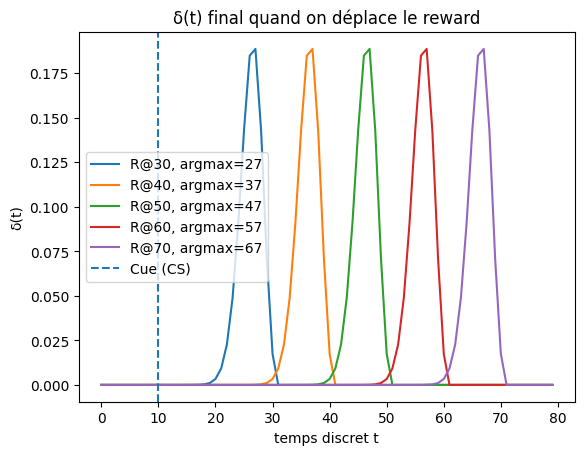

In [137]:
reward_times = [30, 40, 50, 60, 70]
plt.figure()
for rt in reward_times:
    m, d, V = entrainer_modele(alpha=0.05, gamma=0.98, reward_time=rt, n_train=80, T=80, cue_time=10, n_delays=70)
    late = d[-1]
    plt.plot(np.arange(m.T), late, label=f"R@{rt}, argmax={int(np.argmax(late))}")
plt.axvline(10, linestyle="--", label="Cue (CS)")
plt.title("δ(t) final quand on déplace le reward")
plt.xlabel("temps discret t")
plt.ylabel("δ(t)")
plt.legend()
plt.show()


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Quand on change le temps du reward, le pic final de δ(t) suit ce nouveau timing tant que la base temporelle le couvre. Le modèle reste donc flexible sur le délai cue→reward.
</div>


## 10) Exploration 4 — Casser volontairement le modèle : `n_delays` trop court

Si `n_delays` est plus petit que le délai cue→reward, le CS ne peut pas représenter correctement “le futur” jusqu’au reward.
On s’attend à un apprentissage du timing dégradé.


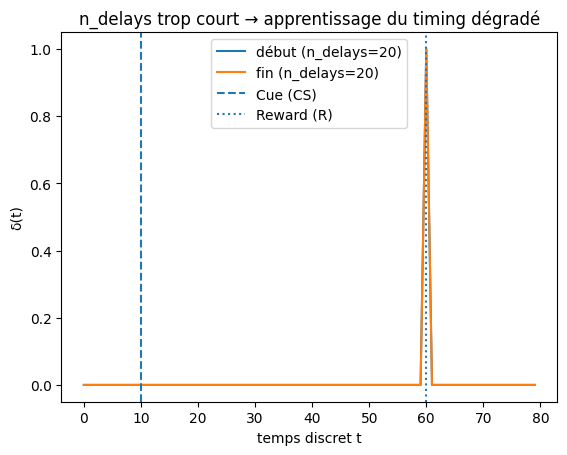

Argmax fin (n_delays=20): 60


In [138]:
m_bad, d_bad, V_bad = entrainer_modele(alpha=0.05, gamma=0.98, reward_time=60, n_train=80, T=80, cue_time=10, n_delays=20)

plt.figure()
plt.plot(np.arange(m_bad.T), d_bad[0], label="début (n_delays=20)")
plt.plot(np.arange(m_bad.T), d_bad[-1], label="fin (n_delays=20)")
plt.axvline(m_bad.cue_time, linestyle="--", label="Cue (CS)")
plt.axvline(m_bad.reward_time, linestyle=":", label="Reward (R)")
plt.title("n_delays trop court → apprentissage du timing dégradé")
plt.xlabel("temps discret t")
plt.ylabel("δ(t)")
plt.legend()
plt.show()

print("Argmax fin (n_delays=20):", int(np.argmax(d_bad[-1])))


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
n_delays trop court empêche de couvrir le délai cue→reward : le pic de δ(t) se décale mal et l’anticipation se dégrade. On voit l’importance d’une représentation temporelle assez longue.
</div>


## 11) Transfert vers le cue le plus précoce

Le papier propose : avec plusieurs cues prédictifs, la réponse phasique devrait transférer au cue **le plus tôt** et fiable.

On simule 2 cues :
- Cue A à t=10 (le plus tôt)
- Cue B à t=20
- Reward à t=60

On somme les valeurs prédites des deux cues.


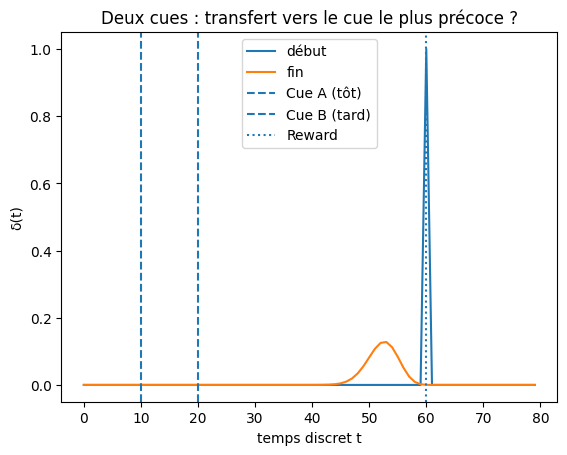

Argmax fin (deux cues): 53


In [139]:
class TDTwoCuesSerialCompound:
    def __init__(self, T=80, cueA_time=10, cueB_time=20, reward_time=60,
                 n_delays=60, alpha=0.05, gamma=0.98):
        self.T = int(T)
        self.cueA_time = int(cueA_time)
        self.cueB_time = int(cueB_time)
        self.reward_time = int(reward_time)
        self.n_delays = int(n_delays)
        self.alpha = float(alpha)
        self.gamma = float(gamma)
        self.wA = np.zeros(self.n_delays, dtype=float)
        self.wB = np.zeros(self.n_delays, dtype=float)

    def x_from_cue(self, t, cue_time):
        vec = np.zeros(self.n_delays, dtype=float)
        delay = t - cue_time - 1
        if 0 <= delay < self.n_delays:
            vec[delay] = 1.0
        return vec

    def Vhat(self, t):
        xA = self.x_from_cue(t, self.cueA_time)
        xB = self.x_from_cue(t, self.cueB_time)
        return float(np.dot(self.wA, xA) + np.dot(self.wB, xB))

    def run_trial(self, reward_delivered=True, reward_value=1.0):
        r = np.zeros(self.T, dtype=float)
        if reward_delivered and 0 <= self.reward_time < self.T:
            r[self.reward_time] = float(reward_value)

        deltas = np.zeros(self.T, dtype=float)
        for t in range(self.T):
            Vt = self.Vhat(t)
            Vnext = self.Vhat(t+1) if t+1 < self.T else 0.0
            delta = r[t] + self.gamma * Vnext - Vt

            xA = self.x_from_cue(t, self.cueA_time)
            xB = self.x_from_cue(t, self.cueB_time)
            self.wA += self.alpha * xA * delta
            self.wB += self.alpha * xB * delta

            deltas[t] = delta

        return deltas, r

two = TDTwoCuesSerialCompound(T=80, cueA_time=10, cueB_time=20, reward_time=60, n_delays=60, alpha=0.05, gamma=0.98)
deltas_hist = []
for _ in range(80):
    d, r = two.run_trial(reward_delivered=True)
    deltas_hist.append(d)
deltas_hist = np.array(deltas_hist)

plt.figure()
plt.plot(np.arange(two.T), deltas_hist[0], label="début")
plt.plot(np.arange(two.T), deltas_hist[-1], label="fin")
plt.axvline(two.cueA_time, linestyle="--", label="Cue A (tôt)")
plt.axvline(two.cueB_time, linestyle="--", label="Cue B (tard)")
plt.axvline(two.reward_time, linestyle=":", label="Reward")
plt.title("Deux cues : transfert vers le cue le plus précoce ?")
plt.xlabel("temps discret t")
plt.ylabel("δ(t)")
plt.legend()
plt.show()

print("Argmax fin (deux cues):", int(np.argmax(deltas_hist[-1])))


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Avec deux cues prédictifs, δ(t) se déplace vers le cue le plus précoce une fois l’apprentissage stabilisé. Le signal d’erreur quitte le reward puis le cue tardif pour se caler sur le cue A, conformément à la prédiction “le signal phasique migre vers le premier indice fiable”.
</div>


### Analyse des variables et objets dans le contexte actuel

Dans cette section, nous examinons les variables et objets pertinents pour l'analyse du modèle TD.

#### Variables principales :
- **`train_d`** : Un tableau numpy (`numpy.ndarray`) contenant les valeurs de l'erreur TD δ(t) pour chaque étape d'apprentissage. Ce tableau montre l'évolution de l'erreur au fil des essais.
- **`train_deltas`** : Un tableau numpy de forme `(80, 80)` représentant les erreurs TD pour 80 essais, chaque essai ayant 80 pas de temps. Ce tableau est utilisé pour visualiser l'évolution de δ(t) sur plusieurs essais.
- **`train_reward_on`** : Une variable entière indiquant le moment où la récompense est délivrée pendant l'entraînement (ici, `t=6`).
- **`train_reward_dur`** : Une variable entière indiquant la durée de la récompense pendant l'entraînement (ici, `1` pas de temps).

#### Objet principal :
- **`two`** : Une instance de la classe `TDTwoCuesSerialCompound`. Cet objet représente un modèle TD avec deux signaux prédictifs (cues) et permet de simuler l'apprentissage et la prédiction de récompenses. Il est utilisé pour analyser le transfert de l'erreur TD vers le cue le plus précoce.

Ces éléments permettent de mieux comprendre les dynamiques d'apprentissage temporel et les mécanismes de prédiction dans le cadre du modèle TD.

In [140]:
import numpy as np

class TDSerialCompoundCueVec:
    """
    TD + représentation CSC (serial compound) construite à partir d'un vecteur cue[t] (0/1).
    Cela permet d'avoir un cue de durée > 1 (comme dans le code RL-tutorial).

    Représentation :
      x_i(t) = cue[t - (i+1)]  si l'indice est valide, sinon 0
    Donc chaque délai i "regarde" si le cue était présent i+1 pas avant.
    """

    def __init__(self, cue_vec, reward_vec, n_delays=60, alpha=0.05, gamma=0.98):
        self.cue = np.asarray(cue_vec, dtype=float).reshape(-1)
        self.r = np.asarray(reward_vec, dtype=float).reshape(-1)
        assert len(self.cue) == len(self.r), "cue_vec et reward_vec doivent avoir la même longueur"

        self.T = len(self.cue)
        self.n_delays = int(n_delays)
        self.alpha = float(alpha)
        self.gamma = float(gamma)
        self.w = np.zeros(self.n_delays, dtype=float)

    def x(self, t):
        x = np.zeros(self.n_delays, dtype=float)
        for i in range(self.n_delays):
            idx = t - (i + 1)
            if 0 <= idx < self.T:
                x[i] = self.cue[idx]
        return x

    def Vhat(self, t):
        return float(np.dot(self.w, self.x(t)))

    def run_trial(self, learn=True):
        deltas = np.zeros(self.T, dtype=float)
        Vhats = np.zeros(self.T, dtype=float)

        for t in range(self.T):
            Vt = self.Vhat(t)
            Vnext = self.Vhat(t + 1) if (t + 1) < self.T else 0.0
            delta = self.r[t] + self.gamma * Vnext - Vt

            if learn:
                self.w += self.alpha * self.x(t) * delta

            deltas[t] = delta
            Vhats[t] = Vt

        return deltas, Vhats


In [141]:
def make_stimulus(T, onset, dur, amp=1.0):
    v = np.zeros(T, dtype=float)
    onset = int(onset); dur = int(dur)
    v[onset:onset+dur] = amp
    return v

def train_then_test(n_train=100, T=10,
                    cue_on=5, cue_dur=2,
                    train_reward_on=6, train_reward_dur=1,
                    test_type="or",  # "or" (omission) | "er" (early) | "dr" (delayed)
                    early_reward_on=2,
                    delayed_reward_on=8,
                    n_delays=20, alpha=0.05, gamma=0.98):
    """
    Entraîne sur n_train trials avec reward standard, puis fait 1 trial de test.
    - or : reward omis
    - er : reward plus tôt
    - dr : reward plus tard

    Renvoie :
      train_deltas (n_train x T), train_V (n_train x T),
      test_delta (T,), test_V (T,), cue_vec (T,), train_reward_vec (T,), test_reward_vec (T,)
    """
    cue_vec = make_stimulus(T, cue_on, cue_dur, amp=1.0)
    train_reward_vec = make_stimulus(T, train_reward_on, train_reward_dur, amp=1.0)

    # --- init modèle (on réutilise les mêmes poids trial après trial)
    model = TDSerialCompoundCueVec(cue_vec, train_reward_vec, n_delays=n_delays, alpha=alpha, gamma=gamma)

    train_deltas = []
    train_V = []
    for _ in range(n_train):
        model.r = train_reward_vec  # reward standard
        d, V = model.run_trial(learn=True)
        train_deltas.append(d); train_V.append(V)

    train_deltas = np.array(train_deltas)
    train_V = np.array(train_V)

    # --- trial de test
    if test_type == "or":
        test_reward_vec = np.zeros(T)
    elif test_type == "er":
        test_reward_vec = make_stimulus(T, early_reward_on, 1, amp=1.0)
    elif test_type == "dr":
        test_reward_vec = make_stimulus(T, delayed_reward_on, 1, amp=1.0)
    else:
        raise ValueError("test_type doit être 'or', 'er' ou 'dr'")

    model.r = test_reward_vec
    test_delta, test_V = model.run_trial(learn=False)  # IMPORTANT : pas d'apprentissage pendant le test

    return train_deltas, train_V, test_delta, test_V, cue_vec, train_reward_vec, test_reward_vec


In [142]:
import matplotlib.pyplot as plt

def plot_delta_train_test(train_deltas, test_delta, cue_vec, train_reward_vec, test_reward_vec, title):
    T = len(cue_vec)
    t = np.arange(T)

    plt.figure()
    plt.plot(t, train_deltas[0], label="Avant apprentissage (trial 1)")
    plt.plot(t, train_deltas[-1], label=f"Après apprentissage (trial {len(train_deltas)})")
    plt.plot(t, test_delta, label="Trial de test", linewidth=2)

    # repères cue / reward
    cue_times = np.where(cue_vec > 0)[0]
    if len(cue_times) > 0:
        plt.axvspan(cue_times[0], cue_times[-1], alpha=0.2, label="Cue (CS)")

    train_r_times = np.where(train_reward_vec > 0)[0]
    if len(train_r_times) > 0:
        plt.axvline(train_r_times[0], linestyle=":", label="Reward (entraînement)")

    test_r_times = np.where(test_reward_vec > 0)[0]
    if len(test_r_times) > 0:
        plt.axvline(test_r_times[0], linestyle="--", label="Reward (test)")

    plt.title(title)
    plt.xlabel("temps discret t")
    plt.ylabel("δ(t)")
    plt.legend()
    plt.show()


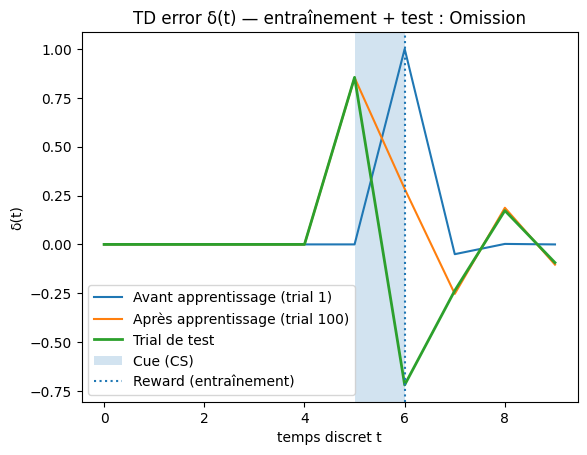

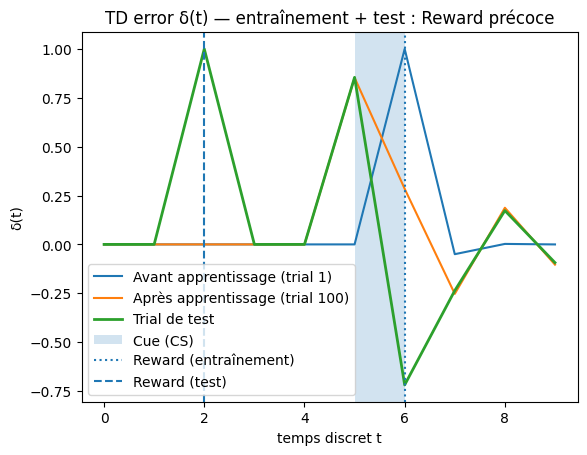

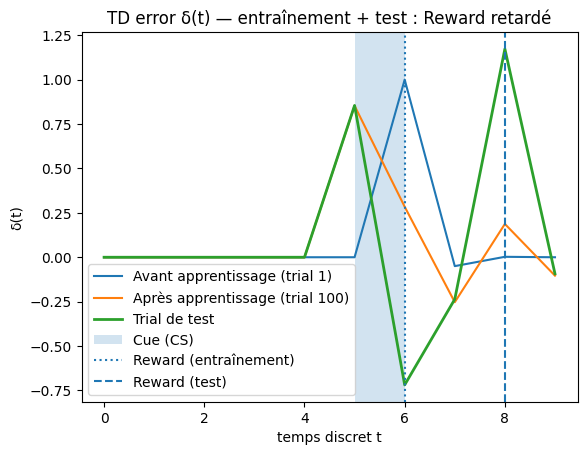

In [143]:
n_train = 100
T = 10
cue_on, cue_dur = 5, 2
train_reward_on, train_reward_dur = 6, 1
early_reward_on = 2
delayed_reward_on = 8

for test_type, name in [("or","Omission"), ("er","Reward précoce"), ("dr","Reward retardé")]:
    train_d, train_V, test_d, test_V, cue, r_train, r_test = train_then_test(
        n_train=n_train, T=T,
        cue_on=cue_on, cue_dur=cue_dur,
        train_reward_on=train_reward_on, train_reward_dur=train_reward_dur,
        test_type=test_type,
        early_reward_on=early_reward_on,
        delayed_reward_on=delayed_reward_on,
        n_delays=20, alpha=0.05, gamma=0.98
    )
    plot_delta_train_test(train_d, test_d, cue, r_train, r_test,
                         title=f"TD error δ(t) — entraînement + test : {name}")


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Sans reward au test, δ(t) plonge négativement au moment attendu : le modèle avait bien anticipé la récompense et signale sa non-délivrance.
</div>


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Reward précoce : pic positif au moment où il tombe, puis dip négatif quand le reward attendu n’arrive plus. Le modèle encode donc finement le timing prévu.
</div>


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Reward retardé : dip négatif à l’instant prévu, puis pic positif quand le reward survient. δ(t) sépare clairement absence du reward attendu et arrivée tardive.
</div>


In [144]:
def plot_value_train_test(train_V, test_V, cue_vec, train_reward_vec, test_reward_vec, title):
    T = len(cue_vec)
    t = np.arange(T)

    plt.figure()
    plt.plot(t, train_V[0], label="Avant apprentissage (trial 1)")
    plt.plot(t, train_V[-1], label=f"Après apprentissage (trial {len(train_V)})")
    plt.plot(t, test_V, label="Trial de test", linewidth=2)

    cue_times = np.where(cue_vec > 0)[0]
    if len(cue_times) > 0:
        plt.axvspan(cue_times[0], cue_times[-1], alpha=0.2, label="Cue (CS)")

    train_r_times = np.where(train_reward_vec > 0)[0]
    if len(train_r_times) > 0:
        plt.axvline(train_r_times[0], linestyle=":", label="Reward (entraînement)")

    test_r_times = np.where(test_reward_vec > 0)[0]
    if len(test_r_times) > 0:
        plt.axvline(test_r_times[0], linestyle="--", label="Reward (test)")

    plt.title(title)
    plt.xlabel("temps discret t")
    plt.ylabel("V̂(t)")
    plt.legend()
    plt.show()


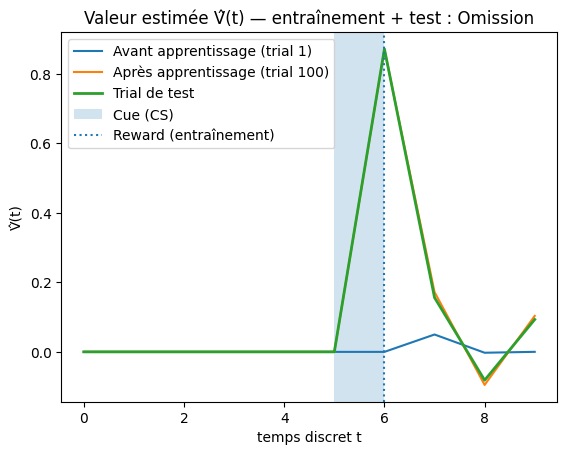

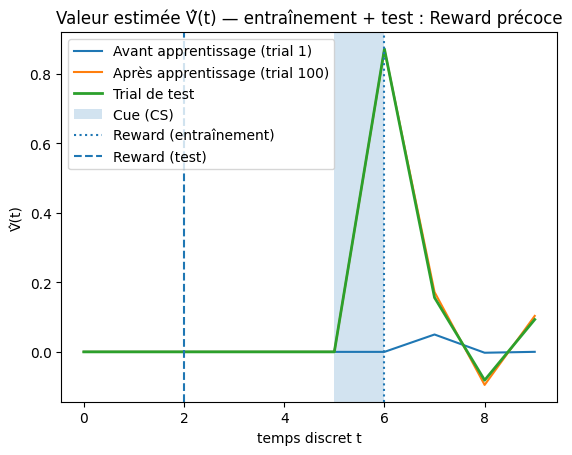

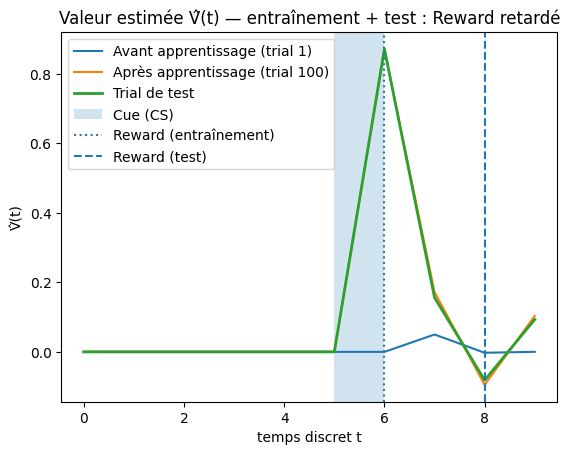

In [145]:
for test_type, name in [("or","Omission"), ("er","Reward précoce"), ("dr","Reward retardé")]:
    train_d, train_V, test_d, test_V, cue, r_train, r_test = train_then_test(
        n_train=100, T=10,
        cue_on=5, cue_dur=2,
        train_reward_on=6, train_reward_dur=1,
        test_type=test_type,
        early_reward_on=2,
        delayed_reward_on=8,
        n_delays=20, alpha=0.05, gamma=0.98
    )
    plot_value_train_test(train_V, test_V, cue, r_train, r_test,
                          title=f"Valeur estimée V̂(t) — entraînement + test : {name}")


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
En omission, V̂(t) reste campée sur l’anticipation apprise malgré l’absence de reward unique : la valeur est une croyance stable, pas un simple reflet de l’essai courant.
</div>


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Reward précoce : V̂(t) ne se décale pas d’emblée vers le nouveau timing. La surprise est capturée par δ(t), tandis que la valeur reste alignée sur ce qui a été appris.
</div>


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Reward retardé : V̂(t) reste centrée sur le timing initial; seule δ(t) signale le retard. La valeur encode l’anticipation stable, l’erreur encode la violation.
</div>


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
V̂(t) porte l’attente moyenne, δ(t) les écarts instantanés. Cette dissociation suit exactement l’interprétation de Schultz–Dayan–Montague.
</div>


In [146]:
def plot_heatmap_with_test(train_deltas, test_delta, cue_vec, train_reward_vec, test_reward_vec, title):
    D = np.vstack([train_deltas, test_delta[None, :]]) 
    plt.figure()
    plt.imshow(D, aspect="auto", origin="lower")
    plt.colorbar(label="δ(t)")
    plt.title(title)
    plt.xlabel("temps discret t")
    plt.ylabel("trial (dernier = test)")

    cue_times = np.where(cue_vec > 0)[0]
    if len(cue_times) > 0:
        plt.axvline(cue_times[0], linestyle="--")
        plt.axvline(cue_times[-1], linestyle="--")

    train_r_times = np.where(train_reward_vec > 0)[0]
    if len(train_r_times) > 0:
        plt.axvline(train_r_times[0], linestyle=":")

    test_r_times = np.where(test_reward_vec > 0)[0]
    if len(test_r_times) > 0:
        plt.axvline(test_r_times[0], linestyle="--")

    plt.show()


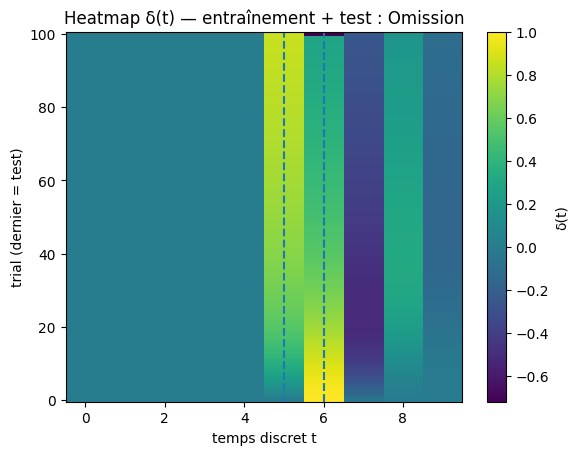

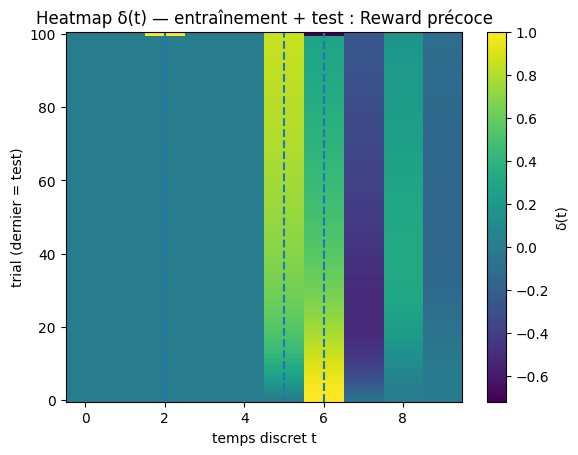

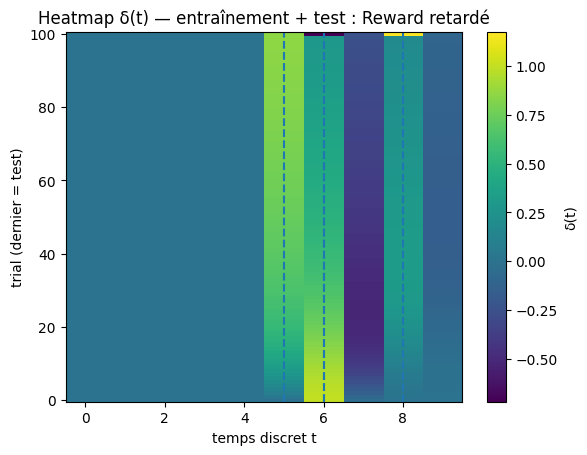

In [147]:
for test_type, name in [("or","Omission"), ("er","Reward précoce"), ("dr","Reward retardé")]:
    train_d, train_V, test_d, test_V, cue, r_train, r_test = train_then_test(
        n_train=100, T=10,
        cue_on=5, cue_dur=2,
        train_reward_on=6, train_reward_dur=1,
        test_type=test_type,
        early_reward_on=2,
        delayed_reward_on=8,
        n_delays=20, alpha=0.05, gamma=0.98
    )
    plot_heatmap_with_test(train_d, test_d, cue, r_train, r_test,
                           title=f"Heatmap δ(t) — entraînement + test : {name}")


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Omission : la heatmap du dernier essai montre une bande négative au temps du reward attendu, signe d’une récompense manquante.
</div>


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Reward précoce : bande positive au moment où il arrive, suivie d’un creux négatif à l’instant où il était prévu. δ(t) encode “reçu trop tôt puis manquant au temps attendu”.
</div>


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Reward retardé : dépression au temps prévu, puis bande positive quand il tombe plus tard. On distingue absence du reward attendu et arrivée tardive.
</div>


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Les trois heatmaps montrent comment δ(t) code les violations temporelles : absence, avance ou retard. L’algorithme capture les signatures dopaminergiques rapportées dans le papier.
</div>


# 13) Blocking 

In [148]:
import numpy as np
import matplotlib.pyplot as plt

def make_stimulus(T, onset, dur, amp=1.0):
    v = np.zeros(T, dtype=float)
    v[int(onset):int(onset)+int(dur)] = amp
    return v

class TDMultiCueCSC:
    """
    TD learning + représentation CSC à partir de vecteurs cue[t] (0/1) pour plusieurs cues.
    Chaque cue k a son propre vecteur de poids w[k, :].
    Vhat(t) = sum_k w_k · x_k(t)  avec x_k CSC construit depuis cue_k.
    """
    def __init__(self, cues_dict, reward_vec, n_delays=30, alpha=0.05, gamma=0.98):
        self.cues = {k: np.asarray(v, dtype=float).reshape(-1) for k, v in cues_dict.items()}
        self.r = np.asarray(reward_vec, dtype=float).reshape(-1)
        self.T = len(self.r)
        for k, v in self.cues.items():
            assert len(v) == self.T, f"cue {k} n'a pas la bonne longueur"
        self.keys = list(self.cues.keys())
        self.K = len(self.keys)

        self.n_delays = int(n_delays)
        self.alpha = float(alpha)
        self.gamma = float(gamma)

        self.w = np.zeros((self.K, self.n_delays), dtype=float)

    def x_csc(self, cue_vec, t):
        x = np.zeros(self.n_delays, dtype=float)
        # x[i] regarde si le cue était actif i+1 pas avant
        for i in range(self.n_delays):
            idx = t - (i + 1)
            if 0 <= idx < self.T:
                x[i] = cue_vec[idx]
        return x

    def Vhat(self, t):
        total = 0.0
        for ki, k in enumerate(self.keys):
            total += np.dot(self.w[ki], self.x_csc(self.cues[k], t))
        return float(total)

    def run_trial(self, learn=True):
        deltas = np.zeros(self.T, dtype=float)
        Vhats = np.zeros(self.T, dtype=float)

        for t in range(self.T):
            Vt = self.Vhat(t)
            Vnext = self.Vhat(t+1) if t+1 < self.T else 0.0
            delta = self.r[t] + self.gamma * Vnext - Vt

            if learn:
                for ki, k in enumerate(self.keys):
                    xk = self.x_csc(self.cues[k], t)
                    self.w[ki] += self.alpha * xk * delta

            deltas[t] = delta
            Vhats[t] = Vt

        return deltas, Vhats


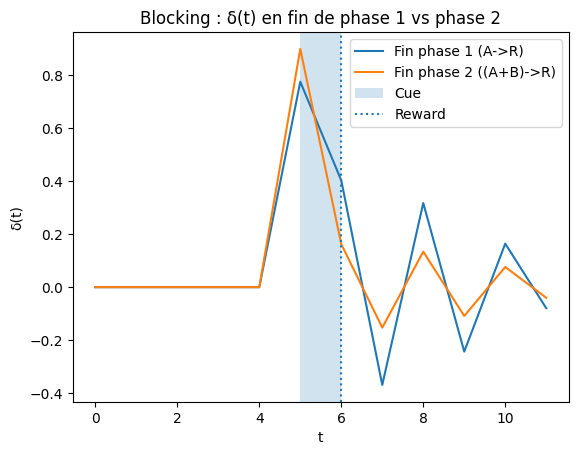

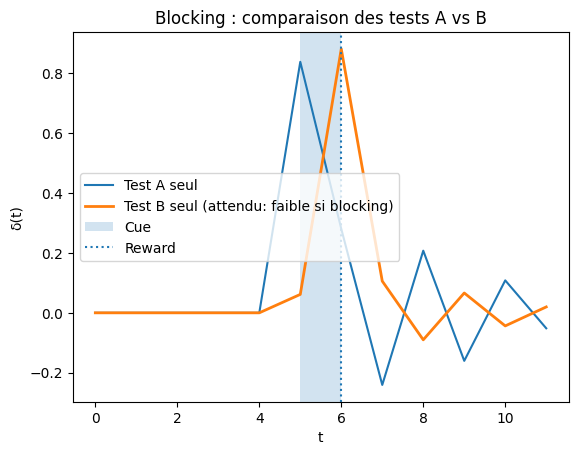

Norme poids A: 1.4962482051926487
Norme poids B: 0.46175184844112593 (attendu: << A si blocking)


In [149]:
def simulate_blocking(
    T=12,
    cue_on=5, cue_dur=2,
    reward_on=6, reward_dur=1,
    n_delays=30, alpha=0.05, gamma=0.98,
    n_phase1=80, n_phase2=80
):
    """
    Phase 1 : A -> R (apprentissage de A)
    Phase 2 : (A+B) -> R (B arrive mais A prédit déjà tout)
    Test : B seul (doit prédire très peu si blocking)
    """
    cueA = make_stimulus(T, cue_on, cue_dur, 1.0)
    cueB = make_stimulus(T, cue_on, cue_dur, 1.0)  # même timing, mais on l'introduit plus tard
    R = make_stimulus(T, reward_on, reward_dur, 1.0)

    # --- Phase 1: A seul
    model = TDMultiCueCSC({"A": cueA, "B": np.zeros(T)}, R, n_delays=n_delays, alpha=alpha, gamma=gamma)
    deltas_p1 = []
    for _ in range(n_phase1):
        d, V = model.run_trial(learn=True)
        deltas_p1.append(d)
    deltas_p1 = np.array(deltas_p1)

    # --- Phase 2: A + B (B présent mais A prédit déjà)
    model.cues["B"] = cueB.copy()
    deltas_p2 = []
    for _ in range(n_phase2):
        d, V = model.run_trial(learn=True)
        deltas_p2.append(d)
    deltas_p2 = np.array(deltas_p2)

    # --- Tests (sans apprentissage)
    # Test A seul
    model.cues["B"] = np.zeros(T)
    dA, VA = model.run_trial(learn=False)

    # Test B seul
    model.cues["A"] = np.zeros(T)
    model.cues["B"] = cueB.copy()
    dB, VB = model.run_trial(learn=False)

    return model, deltas_p1, deltas_p2, dA, dB, cueA, cueB, R

model, d1, d2, dA, dB, cueA, cueB, R = simulate_blocking()

t = np.arange(len(R))

# Plot TD error: fin phase1 vs fin phase2
plt.figure()
plt.plot(t, d1[-1], label="Fin phase 1 (A->R)")
plt.plot(t, d2[-1], label="Fin phase 2 ((A+B)->R)")
plt.axvspan(np.where(cueA>0)[0][0], np.where(cueA>0)[0][-1], alpha=0.2, label="Cue")
plt.axvline(np.where(R>0)[0][0], linestyle=":", label="Reward")
plt.title("Blocking : δ(t) en fin de phase 1 vs phase 2")
plt.xlabel("t")
plt.ylabel("δ(t)")
plt.legend()
plt.show()

# Test A seul vs B seul
plt.figure()
plt.plot(t, dA, label="Test A seul")
plt.plot(t, dB, label="Test B seul (attendu: faible si blocking)", linewidth=2)
plt.axvspan(np.where(cueA>0)[0][0], np.where(cueA>0)[0][-1], alpha=0.2, label="Cue")
plt.axvline(np.where(R>0)[0][0], linestyle=":", label="Reward")
plt.title("Blocking : comparaison des tests A vs B")
plt.xlabel("t")
plt.ylabel("δ(t)")
plt.legend()
plt.show()

# Mesure simple : norme des poids pour A et B
wA_norm = np.linalg.norm(model.w[model.keys.index("A")])
wB_norm = np.linalg.norm(model.w[model.keys.index("B")])
print("Norme poids A:", wA_norm)
print("Norme poids B:", wB_norm, "(attendu: << A si blocking)")


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Blocking : B n’apporte rien quand A prédit déjà tout, donc B est peu appris et sa réponse reste faible. Sans erreur résiduelle, pas de signal d’enseignement pour B.
</div>


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Comparaison des phases : δ(t) change peu entre A→R et (A+B)→R, preuve que B ne génère pas d’erreur supplémentaire. L’apprentissage de B reste bloqué.
</div>


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Tests finaux : A seul déclenche une prédiction forte, B seul reste faible. B n’a pas été appris comme prédicteur principal parce que la récompense était déjà expliquée par A.
</div>


# 14) Séquence “Cue1 → Cue2 → Reward” + omission de Cue2

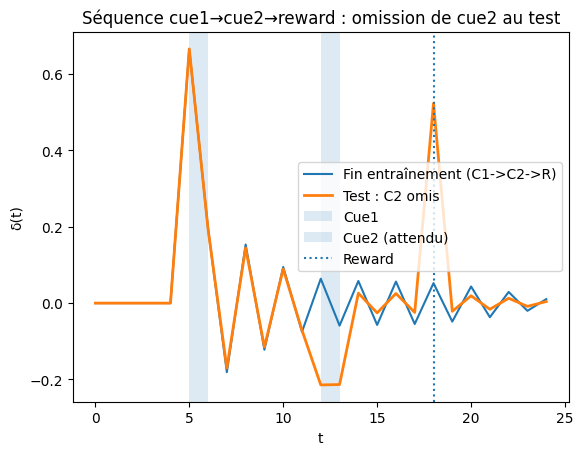

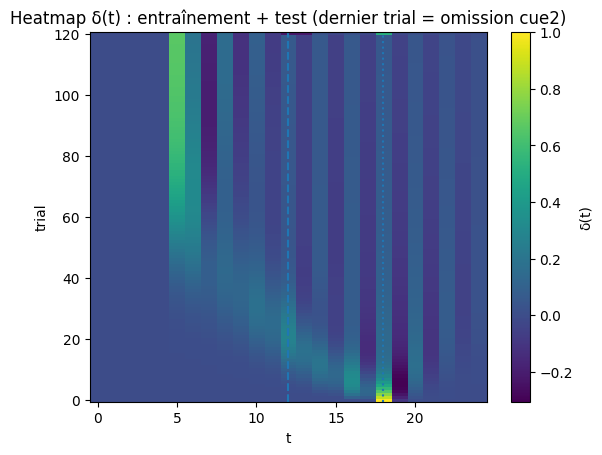

δ(t) au temps cue2 attendu (début de cue2): -0.21437384796123848


In [150]:
def simulate_cue_sequence_omit_cue2(
    T=25,
    cue1_on=5, cue1_dur=2,
    cue2_on=12, cue2_dur=2,
    reward_on=18, reward_dur=1,
    n_train=120,
    n_delays=40, alpha=0.05, gamma=0.98
):
    """
    Entraînement : cue1 -> cue2 -> reward
    Test : cue1 présent, cue2 omis, reward toujours au même temps
    Attendu : dip négatif au temps de cue2 (car cue2 était attendu).
    """
    cue1 = make_stimulus(T, cue1_on, cue1_dur, 1.0)
    cue2 = make_stimulus(T, cue2_on, cue2_dur, 1.0)
    R = make_stimulus(T, reward_on, reward_dur, 1.0)

    # Entraînement avec les deux cues
    model = TDMultiCueCSC({"C1": cue1, "C2": cue2}, R, n_delays=n_delays, alpha=alpha, gamma=gamma)

    deltas = []
    for _ in range(n_train):
        d, V = model.run_trial(learn=True)
        deltas.append(d)
    deltas = np.array(deltas)

    # Test : omission de cue2 (mais cue1 présent)
    model.cues["C2"] = np.zeros(T)
    d_test, V_test = model.run_trial(learn=False)

    return deltas, d_test, cue1, cue2, R

d_train, d_test, cue1, cue2, R = simulate_cue_sequence_omit_cue2()

t = np.arange(len(R))

# δ(t) fin entraînement vs test
plt.figure()
plt.plot(t, d_train[-1], label="Fin entraînement (C1->C2->R)")
plt.plot(t, d_test, label="Test : C2 omis", linewidth=2)
plt.axvspan(np.where(cue1>0)[0][0], np.where(cue1>0)[0][-1], alpha=0.15, label="Cue1")
plt.axvspan(np.where(cue2>0)[0][0], np.where(cue2>0)[0][-1], alpha=0.15, label="Cue2 (attendu)")
plt.axvline(np.where(R>0)[0][0], linestyle=":", label="Reward")
plt.title("Séquence cue1→cue2→reward : omission de cue2 au test")
plt.xlabel("t")
plt.ylabel("δ(t)")
plt.legend()
plt.show()

# Heatmap train + test
D = np.vstack([d_train, d_test[None,:]])
plt.figure()
plt.imshow(D, aspect="auto", origin="lower")
plt.colorbar(label="δ(t)")
plt.title("Heatmap δ(t) : entraînement + test (dernier trial = omission cue2)")
plt.xlabel("t")
plt.ylabel("trial")
plt.axvline(np.where(cue2>0)[0][0], linestyle="--")
plt.axvline(np.where(R>0)[0][0], linestyle=":")
plt.show()

print("δ(t) au temps cue2 attendu (début de cue2):", d_test[np.where(cue2>0)[0][0]])


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Omettre cue2 après avoir appris cue1→cue2→reward crée une dépression de δ(t) au temps prévu de cue2. Le modèle attend donc aussi les événements intermédiaires, pas seulement le reward final.
</div>


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Comparaison entraînement vs test : la chute de δ(t) n’apparaît qu’en test quand cue2 manque. Le modèle encode la séquence, pas uniquement la récompense finale.
</div>


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
La heatmap finale montre un creux localisé au temps de cue2 absent, malgré un reward délivré ensuite. L’erreur vient de l’événement manquant dans la séquence.
</div>


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Le modèle signale toute violation de la séquence apprise, y compris l’omission d’un cue intermédiaire non récompensant : δ(t) sert bien d’erreur de prédiction temporelle générale.
</div>


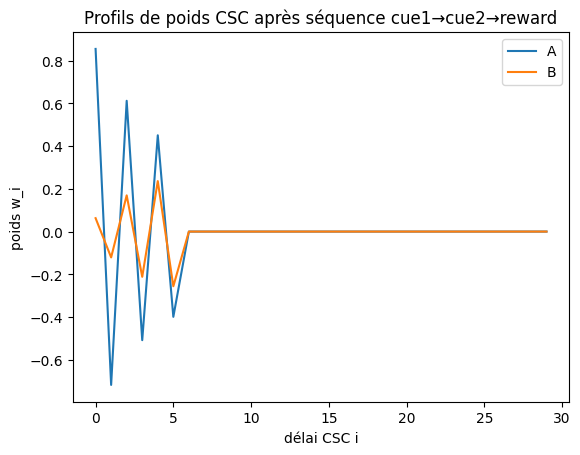

In [151]:
def plot_weight_profiles(model, title="Profils de poids CSC"):
    plt.figure()
    for ki, k in enumerate(model.keys):
        plt.plot(model.w[ki], label=f"{k}")
    plt.title(title)
    plt.xlabel("délai CSC i")
    plt.ylabel("poids w_i")
    plt.legend()
    plt.show()

plot_weight_profiles(model, title="Profils de poids CSC après séquence cue1→cue2→reward")


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Profils de poids CSC : les poids se concentrent sur les délais qui prédisent le mieux le reward, et le cue amont porte des poids plus forts. Le modèle distribue le crédit sur les composantes temporelles utiles.
</div>


## Conclusion

Ce notebook montre comment un modèle de Temporal Difference learning,
combiné à une représentation temporelle simple (serial compound),
permet de reproduire les principales observations du signal dopaminergique.

Le point clé n’est pas le code, mais le fait que :
- la dopamine code une erreur de prédiction,
- cette erreur est définie sur des états temporels,
- l’apprentissage déplace le signal du reward vers le cue.

Le modèle ne prétend pas être biologiquement complet,
mais il fournit une explication computationnelle minimale et testable.
